## **Lab 9: Super Resolution**

In this lab, we are implementing an approach for performing super resolution from "Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network" - Shi et al. based on a pytorch tutorial. We'll first build ESPCN and train it on BSDS300 dataset. Then, we'll compare its upscaling result with that of the conventional bicubic image interpolation.

Efficient Sub-Pixel Convolutional Neural (ESPCN) handles the upscaling step in the last layer to reduce the computational cost of intermideate interpolation layers. The network structure of ESPCN is shown below.
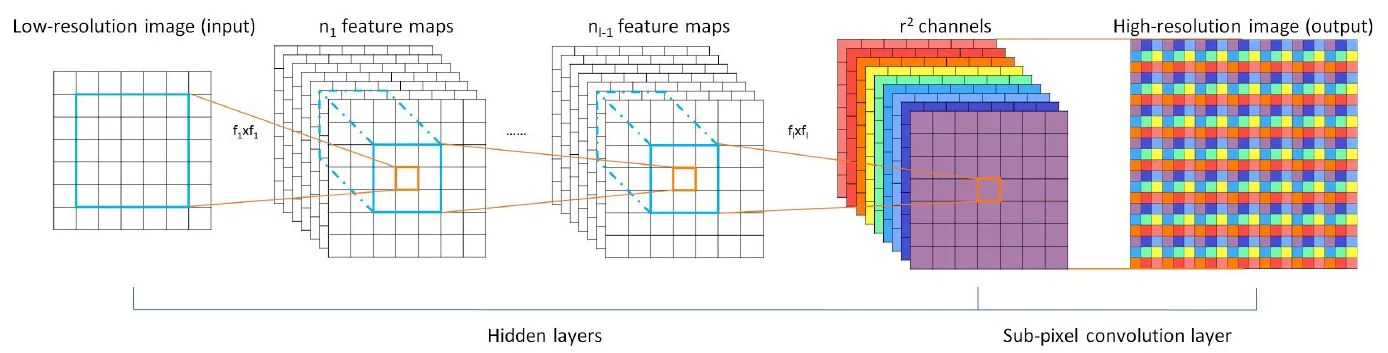

We've provided the training and test dataloaders for BSDS300 dataset. In this part, we preprocess the image to a pytorch tensor of range [-1,1]. The input low resolution image can be resized to 256 x 256. The target high resolution image size is determined by a upscaling factor, which we set to be 3. 
Given this information, let's implement the ```input_transform``` and ```target_transform``` functions below.



In [1]:
from __future__ import print_function
import argparse
from math import log10

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [6]:
from os.path import exists, join, basename
from os import makedirs, remove
from six.moves import urllib
import tarfile
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y


class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = input.copy()
        if self.input_transform:
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.image_filenames)

def download_bsd300(dest="dataset"):
    """
    Download BSD300 dataset from the web.
    """

    output_image_dir = join(dest, "BSDS300/images")

    if not exists(output_image_dir):
        makedirs(dest)
        url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        print("downloading url ", url)

        data = urllib.request.urlopen(url)

        file_path = join(dest, basename(url))
        with open(file_path, 'wb') as f:
            f.write(data.read())

        print("Extracting data")
        with tarfile.open(file_path) as tar:
            for item in tar:
                tar.extract(item, dest)

        remove(file_path)

    return output_image_dir


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def input_transform(crop_size, upscale_factor):
    """
    Preprocess the input to be a low resolution image.
    :param crop_size: the desired size of the image after cropping.
    :param upscale_factor: the upscaling factor for the high resolution image.

    :return: a sequence of torchvision.transforms functions, see torchvision.transforms.Compose.
    """
    transformed = Compose([
        CenterCrop(crop_size),
        Resize(crop_size // upscale_factor),
        ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    return transformed


def target_transform(crop_size):
    """
    Preprocess the input to be the target output image.
    :param crop_size: the desired size of the output image after cropping.

    :return: a sequence of torchvision.transforms functions, see torchvision.transforms.Compose.
    """
    transformed = Compose([
        CenterCrop(crop_size),
        ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    return transformed


def get_training_set(upscale_factor):
    """
    Construct a dataloader for training.
    """

    root_dir = download_bsd300()
    train_dir = join(root_dir, "train")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(train_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))


def get_test_set(upscale_factor):
    """
    Construct a dataloader for test.
    """

    root_dir = download_bsd300()
    test_dir = join(root_dir, "test")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(test_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform(crop_size))

We've got the dataloaders. Now let's build the network from scratch. Detailed architectures are shown below
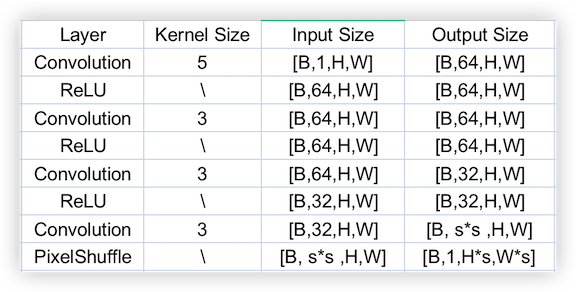

In [7]:
import torch
import torch.nn as nn
import torch.nn.init as init


class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=(upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.upscale_factor = upscale_factor

        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.pixel_shuffle(x)
        result = x

        assert result.shape[2]==x.shape[2]*self.upscale_factor 
        assert result.shape[3]==x.shape[3]*self.upscale_factor 
        return result

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

Let's train the model. It takes about 3 minutes on GPU.

In [8]:
# Training settings
upscale_factor = 3
batchSize = 32
testBatchSize = 100
nEpochs = 50
lr = 0.001
seed = 123

torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print('===> Loading datasets')
train_set = get_training_set(upscale_factor)
test_set = get_test_set(upscale_factor)
training_data_loader = DataLoader(dataset=train_set,  batch_size=batchSize, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, batch_size=testBatchSize, shuffle=False)

print('===> Building model')
model = Net(upscale_factor=upscale_factor).to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=lr)

def test():
    avg_psnr = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = NotImplemented #obtained from batch
            prediction = NotImplemented #get the predicted image from the model
            mse = criterion(prediction, target) 
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

for epoch in range(1, nEpochs + 1):
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = NotImplemented #obtained from batch

        # set optimizer's gradeint to 0
        NotImplemented 

        # compare the predicted image with the target image using MSE loss 
        loss = NotImplemented        
        epoch_loss += loss.item()

        # obtain gradient by backpropogation
        NotImplemented 

        # apply gradient descent step using the optimizer
        NotImplemented

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

    test()

===> Loading datasets


NameError: name 'torchvision' is not defined

In [ ]:
# Training settings
upscale_factor = 3
batchSize = 32
testBatchSize = 100
nEpochs = 50
lr = 0.001
seed = 123

torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print('===> Loading datasets')
train_set = get_training_set(upscale_factor)
test_set = get_test_set(upscale_factor)
training_data_loader = DataLoader(dataset=train_set,  batch_size=batchSize, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, batch_size=testBatchSize, shuffle=False)

print('===> Building model')
model = Net(upscale_factor=upscale_factor).to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=lr)

def test():
    avg_psnr = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = NotImplemented #obtained from batch
            prediction = NotImplemented #get the predicted image from the model
            mse = criterion(prediction, target) 
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

for epoch in range(1, nEpochs + 1):
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = NotImplemented #obtained from batch

        # set optimizer's gradeint to 0
        NotImplemented 

        # compare the predicted image with the target image using MSE loss 
        loss = NotImplemented        
        epoch_loss += loss.item()

        # obtain gradient by backpropogation
        NotImplemented 

        # apply gradient descent step using the optimizer
        NotImplemented

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

    test()


===> Loading datasets
===> Building model
===> Epoch[1](1/7): Loss: 0.4466
===> Epoch[1](2/7): Loss: 0.1623
===> Epoch[1](3/7): Loss: 0.0595
===> Epoch[1](4/7): Loss: 0.0587
===> Epoch[1](5/7): Loss: 0.0579
===> Epoch[1](6/7): Loss: 0.0481
===> Epoch[1](7/7): Loss: 0.0358
===> Epoch 1 Complete: Avg. Loss: 0.1241
===> Avg. PSNR: 14.3969 dB
===> Epoch[2](1/7): Loss: 0.0331
===> Epoch[2](2/7): Loss: 0.0290
===> Epoch[2](3/7): Loss: 0.0223
===> Epoch[2](4/7): Loss: 0.0251
===> Epoch[2](5/7): Loss: 0.0231
===> Epoch[2](6/7): Loss: 0.0249
===> Epoch[2](7/7): Loss: 0.0263
===> Epoch 2 Complete: Avg. Loss: 0.0263
===> Avg. PSNR: 16.2399 dB
===> Epoch[3](1/7): Loss: 0.0222
===> Epoch[3](2/7): Loss: 0.0219
===> Epoch[3](3/7): Loss: 0.0167
===> Epoch[3](4/7): Loss: 0.0170
===> Epoch[3](5/7): Loss: 0.0162
===> Epoch[3](6/7): Loss: 0.0150
===> Epoch[3](7/7): Loss: 0.0129
===> Epoch 3 Complete: Avg. Loss: 0.0174
===> Avg. PSNR: 18.3002 dB
===> Epoch[4](1/7): Loss: 0.0131
===> Epoch[4](2/7): Loss: 0.

After a few epochs of training, we can test the model's performance on an example as shown below. Note that the model only takes the Y channel (in a YCbCr coror space) of the image as input.

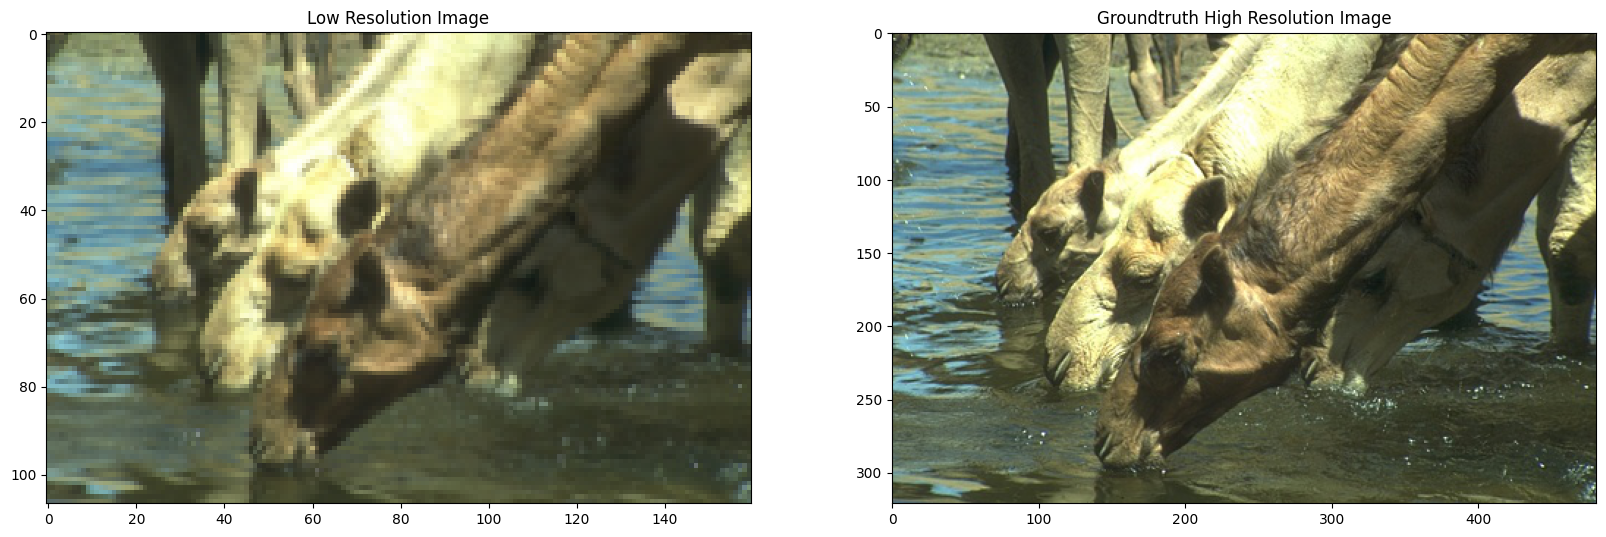

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

input_image = 'dataset/BSDS300/images/test/16077.jpg'

img = Image.open(input_image)

plt.figure(figsize=(20,10))
plt.subplot(122)
plt.imshow(img)
plt.title('Groundtruth High Resolution Image')

img=img.resize((img.size[0]//upscale_factor,img.size[1]//upscale_factor),resample=2)

plt.subplot(121)
plt.imshow(img)
plt.title('Low Resolution Image')

img=img.convert('YCbCr')
y, cb, cr = img.split()

img_to_tensor = ToTensor()
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]).to(device)





Let's compare the bicubic upsampled image with the image proceude by our super resolution model.

Text(0.5, 1.0, 'Bicubic Image')

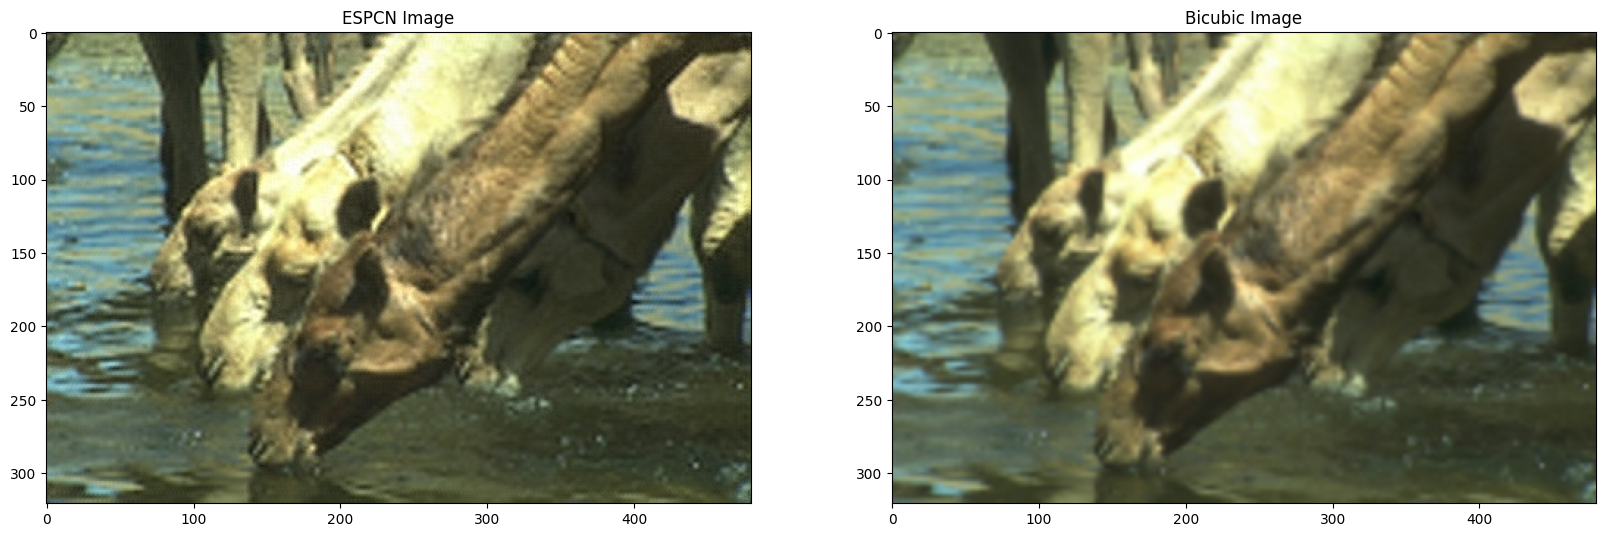

In [ ]:
out = model(input)
out = out.cpu()
out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')

plt.figure(figsize=(20,10))

plt.subplot(121)
plt.imshow(out_img)
plt.title('ESPCN Image')

bicubic_out_img_y = y.resize(out_img_y.size, Image.BICUBIC)
bicubic_out_img = Image.merge('YCbCr', [bicubic_out_img_y, out_img_cb, out_img_cr]).convert('RGB')

plt.subplot(122)
plt.imshow(bicubic_out_img)
plt.title('Bicubic Image')
